In [1]:
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import math
import matplotlib.font_manager as fm

In [2]:
from utils.plot_fig import plot_lr_all_info, plot_static_semilogy
from utils.doubly_random_matrix import get_strongly_connected_directed_row_column_stochastic_matrix
from utils.stepsize_alg import get_stepsize, get_beta1t
from utils.load_logistic_regression_data import (
    load_mnist_data,
    load_covtype_data,
    load_cifar10_data,
    load_fashion_mnist_data,
)
from utils.random_quantizer import probabilistic_quantizer
from utils.summary_writer import get_summary_writer
from utils.model_metrics import get_scores
from utils.data_recorder import LRTrainingRecorder

# 0 预备

In [3]:
# 设置字体优先级：中文用宋体，英文用 Times New Roman

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # ✅ 宋体+Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

# 指定中英文字体路径
chinese_font_path = 'C:/Windows/Fonts/simsun.ttc'  # 替换为你的宋体路径
english_font_path = 'C:/Windows/Fonts/times.ttf'   # 替换为 Times New Roman 路径

chinese_font = fm.FontProperties(fname=chinese_font_path)
english_font = fm.FontProperties(fname=english_font_path)

# 1 导入数据

In [4]:
data_name="fashion-mnist"

In [5]:

if data_name=="mnist":
    mnist_path = r".\data\mnist\6000_data_0.001.mat"
    (
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        lambda_val,
        dims,
        cls_nums,
        nums,
    ) = load_fashion_mnist_data(mnist_path)
elif data_name=="fashion-mnist":
    fashion_mnist_path=r".\data\fashion_mnist"
    (
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        lambda_val,
        dims,
        cls_nums,
        nums,
    ) = load_fashion_mnist_data(fashion_mnist_path)
elif data_name=="cifar10":
    cifar_10_path=r"data\cifar-10\cifar-10-batches-py"
    ( 
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        dims,
        cls_nums,
        nums
      ) = load_cifar10_data(cifar_10_path)

In [6]:
print((dims, nums))

(784, 60000)


In [7]:
x_train.shape

(784, 60000)

In [8]:
y_train.shape

(10, 60000)

## 1.2 导入算法

In [9]:
alg_table={
    "q-pdq":False,
    "q-dadam-ps":False,
    "dadam-ps":False,
    "cal":True
}

# 2 初始化

## 2.1 初始化模型参数

In [10]:
np.random.seed(42)

In [11]:
w_init = np.random.randn(dims, cls_nums if cls_nums > 2 else 1)

In [12]:
w_init.shape

(784, 10)

In [13]:
epsilon = 1e-5

In [14]:
# 最大迭代次数
epoch_num = 500

In [15]:
agents_num = 10

In [16]:
y_train.shape

(10, 60000)

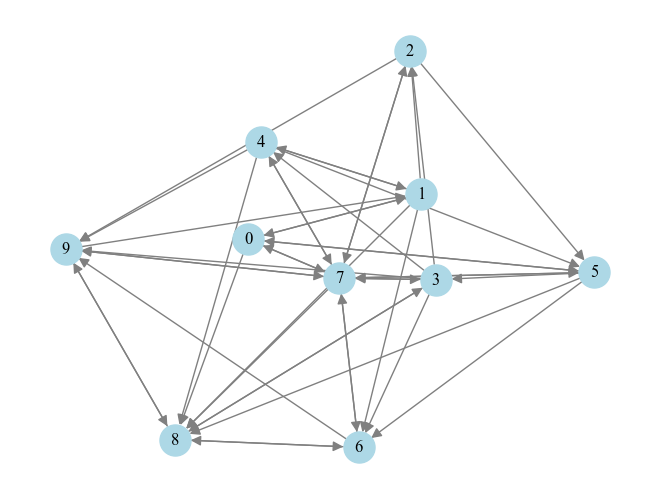

In [17]:
R,C = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num,show=True)
net = C.T

## 2.2 设置损失函数

In [18]:
def softmax(scores):
    max_scores = np.max(scores, axis=0, keepdims=True)
    shifted_scores = scores - max_scores
    exp_scores = np.exp(shifted_scores)
    sum_exp_scores = np.sum(exp_scores, axis=0, keepdims=True)
    return exp_scores / sum_exp_scores

In [19]:
def loss_fn(x, y, w):
    samples_num = y.shape[1]
    scores = np.dot(w.T, x)
    predictions = softmax(scores)
    loss = -np.sum(y * np.log(predictions + epsilon)) / samples_num
    return loss

In [20]:
def grad_fn(x, y, w):
    samples_num = y.shape[1]
    scores = np.dot(w.T, x)
    predictions = softmax(scores)
    output_error = predictions - y

    return np.dot(x, output_error.T) / samples_num

In [21]:
def predict(w, x):
    scores = np.dot(w.T, x)
    predictions = softmax(scores)
    predicted = np.argmax(predictions, axis=0)
    return predicted

In [22]:
import numpy as np
import math

class BitCounter:
    def __init__(self):
        self.record_dict = {
            "original": 0,
            "0.6": 0,
            "1.5": 0,
            "3.0": 0,
        }
        self.record_ls_dict = {
            "original": [],
            "0.6": [],
            "1.5": [],
            "3.0": [],
        }

    def update(self, i, v, size, scheme=None):
        # 原始数据按 32 位浮点数（4 字节）计算比特数
        self.record_dict["original"] += int(size * 32)
        
        # 如果指定了方案，则只更新该方案，否则对所有方案更新
        schemes = [scheme] if scheme is not None else ["0.6", "1.5", "3.0"]
        for s in schemes:
            # 根据当前迭代轮数 i 计算对应的量化参数
            kt_scheme = max(1, min(math.ceil((i+1) ** float(s)), 2**20))
            # 对 v 进行量化：先放缩，再取 floor 与 ceil
            floor_int = np.floor(v * kt_scheme).astype(np.int32)
            ceil_int  = np.ceil(v * kt_scheme).astype(np.int32)
            r = np.random.rand(*v.shape)
            diff = v * kt_scheme - floor_int  # 小数部分
            mask = r < diff
            q_int = np.where(mask, floor_int, ceil_int)
            
            # 根据 q_int 的最大值动态计算实际需要的 bit_width
            max_val = q_int.max()
            bit_width = int(np.ceil(np.log2(max_val + 1))) if max_val > 0 else 1

            # 根据打包后的字节串长度计算实际通信比特数
            packed_data_bytes = calculate_bytes(q_int,bit_width)
            comm_bits=(packed_data_bytes+1)*8
            self.record_dict[s] += comm_bits

    def update_ls(self):
        # 将累计比特数转换为 Mbits（1e6 bit）
        self.record_ls_dict["original"].append(self.record_dict["original"] / 1e6)
        for scheme in ["0.6", "1.5", "3.0"]:
            self.record_ls_dict[scheme].append(self.record_dict[scheme] / 1e6)



bit_counter = BitCounter()

def calculate_bytes(q, bit_width):
    total_bits = q.size * bit_width  # ✅ 正确：q.size获取总元素数
    num_bytes = (total_bits + 7) // 8
    return num_bytes

def cal_probabilistic_quantizer(v, kt, scheme=None, i=None, record=True, use_quantize=True):

    # 如果指定了方案，则只更新该方案，否则更新所有方案
    bit_counter.update(i, v, v.size, scheme)
    
    return 1





In [23]:
quantizer=cal_probabilistic_quantizer

In [24]:
record_accuracy_dict={
    
}

## 2.3 初始化LRTrainingRecorder和SummaryWriter

In [25]:
training_recorder=LRTrainingRecorder(is_binary=False)

In [26]:
writer = get_summary_writer(f"./logs/qdadamPS_compare_multi_logistic_regression/{data_name}")
# pic_save_path = "./results/dadam_batch_size_1000"

# 5 Q-DADAM-Push-Sum模型训练

## 5.1 设置优化器初始参数

In [27]:

# 初始步长

step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

In [28]:
# 批量大小
batch_size = 1000
sample_nums_per_agent=math.ceil(nums/agents_num)

In [29]:
beta1t_lambda=0.9

In [30]:
kt_pow=1.5

## 5.2 初始化优化器

In [31]:
w_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# x_hat_node 初始化为0
quant_x_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
quant_x_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
m_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_hat_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_node = np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
v_bar_prev_node = G0**2 * np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))


x_hat_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
x_hat_prev_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))
# y_node 初始化为1
y_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))
y_prev_node=np.ones((agents_num, dims, cls_nums if cls_nums > 2 else 1))

z_node=np.zeros((agents_num, dims, cls_nums if cls_nums > 2 else 1))


In [32]:
for ii in range(agents_num):
    w_node[ii] = w_init.copy()
    quant_x_node[ii]=w_init

    x_node[ii]=w_init.copy()
    x_prev_node[ii]=w_init.copy()

    z_node[ii]=w_init.copy()

In [33]:
batch_nums = math.ceil(nums / (batch_size*agents_num))

In [34]:
total_iter = 0

## 5.3 模型训练

In [35]:
# 算法名称
alg_name="cal"
record_accuracy_ls=[]
if alg_table[alg_name]:
    
    alg_label = f"method_{alg_name}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
    # 初始化 训练过程记录
    training_recorder.init_alg_model(alg_label)
    # 记录初始状态
    training_recorder.auto_cal_and_append(alg_label,np.mean(w_node,axis=0),w_opt,loss_fn,get_scores,predict,x_train,y_train,x_test,y_test)

    pbar=tqdm(total=epoch_num)
    for i in trange(epoch_num):
        pbar.update()
        # 限制量化最大值，对于32位浮点数，不能超过 2**32
        kt = min(math.ceil((i+1)**kt_pow),2**20)
        # _,net = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num)
        for j in range(batch_nums):
            total_iter = total_iter + 1
            
            beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)
            step=get_stepsize(step_init,total_iter,method="decay-sq")
            for ii in range(agents_num):
                
                # 对权重进行量化
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    if net[ii,jj]>0:
                        mu=2.718877650738594 
                        sigma=2.752345579703048 
                        shape=(784, 10)
                        w=np.random.normal(mu, sigma, shape)
                        packed = cal_probabilistic_quantizer(v=w,kt=kt, i=total_iter, record=True)
                        


        bit_counter.update_ls()
        pbar.set_postfix(original_bits=bit_counter.record_ls_dict["original"][-1],
                         quantized_bits_0p6=bit_counter.record_ls_dict["0.6"][-1],
                         quantized_bits_1p5=bit_counter.record_ls_dict["1.5"][-1],
                        quantized_bits_3p0=bit_counter.record_ls_dict["3.0"][-1],
                         gen=i+1)


100%|██████████| 500/500 [01:57<00:00,  4.24it/s] gen=500, original_bits=41395.2, quantized_bits_0p6=1.34e+4, quantized_bits_1p5=2.51e+4, quantized_bits_3p0=3.09e+4]


# 数据处理

In [36]:
def smoothing(x ,smooth=0.99):
    """
    The smoothing function takes in a list of numbers and returns the same list with each number replaced by
    the average of itself and all previous numbers. The optional argument smooth is used to determine how much weight
    to give to the previous values, with 0 being no weight at all (i.e., just return the original array) and 1 giving
    equal weight to all values.

    :param x: Pass the data to be smoothed
    :param smooth: Control the amount of smoothing
    :return: A new array with the smoothed values
    :doc-author: Trelent
    """
    x = x.copy()
    weight = smooth
    for i in range(1 ,len(x)):
        x[i] = (x[ i -1] * weight + x[i]) / (weight + 1)
        weight = (weight + 1) * smooth
    return x

### 中文绘图

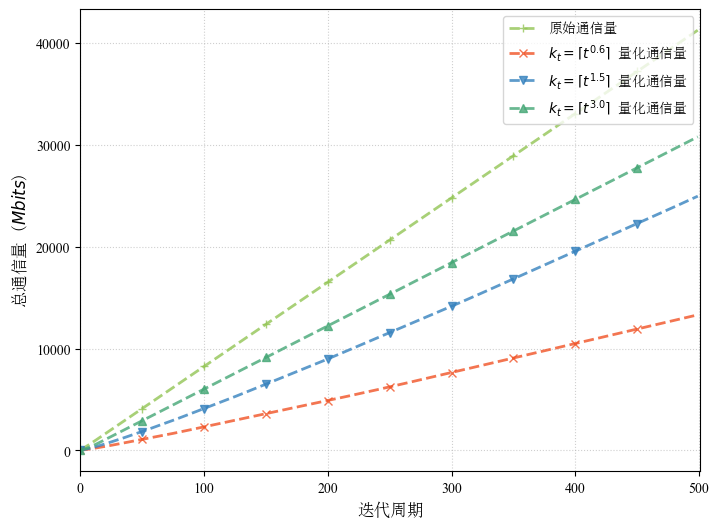

In [37]:

color_ls = ["93c555","f05326","3682be","45a776"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

record_dict={
    "total_original_bits":bit_counter.record_ls_dict["original"],
    "total_quantized_bits_0p6":bit_counter.record_ls_dict["0.6"],
     "total_quantized_bits_1p5":bit_counter.record_ls_dict["1.5"],
     "total_quantized_bits_3p0":bit_counter.record_ls_dict["3.0"],
}

name_dict={
    "total_original_bits":"原始通信量",
    "total_quantized_bits_0p6":r"$k_t=\lceil t^{0.6} \rceil$ 量化通信量",
    "total_quantized_bits_1p5":r"$k_t=\lceil t^{1.5} \rceil$ 量化通信量",
    "total_quantized_bits_3p0":r"$k_t=\lceil t^{3.0} \rceil$ 量化通信量",
}

fig, ax1 = plt.subplots(
        figsize=(8, 6),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_dict):
    ls=record_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6), '--', linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=name_dict[key])
ax1.set_xlabel('迭代周期', fontsize=12,fontproperties=chinese_font)
ax1.set_ylabel('总通信量 ($Mbits$)', fontsize=12,fontproperties=chinese_font)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right',prop=chinese_font)
ax1.grid(True, linestyle=':', alpha=0.6)

ext="png"
fig.savefig(
    fname=f"figs/cal-communication-q-dadam-ps-muilt-lr-{data_name}.png",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


In [38]:
# 训练结束后计算节省比例
total_original_bits=bit_counter.record_ls_dict["original"][-1]
for key in bit_counter.record_ls_dict:
    if key=="original":
        continue
    
    total_quantized_bits=bit_counter.record_ls_dict[key][-1]
    saved_bits = total_original_bits - total_quantized_bits
    saved_ratio = saved_bits / total_original_bits * 100

    print(f"[{key}通信量统计]")
    print(f"原始总比特数: {total_original_bits:.2f} Mbits")
    print(f"量化后总比特数: {total_quantized_bits :.2f} Mbits")
    print(f"节省比特数: {saved_bits :.2f} Mbits")
    print(f"节省比例: {saved_ratio:.2f}%")

[0.6通信量统计]
原始总比特数: 41395.20 Mbits
量化后总比特数: 13352.50 Mbits
节省比特数: 28042.70 Mbits
节省比例: 67.74%
[1.5通信量统计]
原始总比特数: 41395.20 Mbits
量化后总比特数: 25050.26 Mbits
节省比特数: 16344.94 Mbits
节省比例: 39.49%
[3.0通信量统计]
原始总比特数: 41395.20 Mbits
量化后总比特数: 30889.11 Mbits
节省比特数: 10506.09 Mbits
节省比例: 25.38%


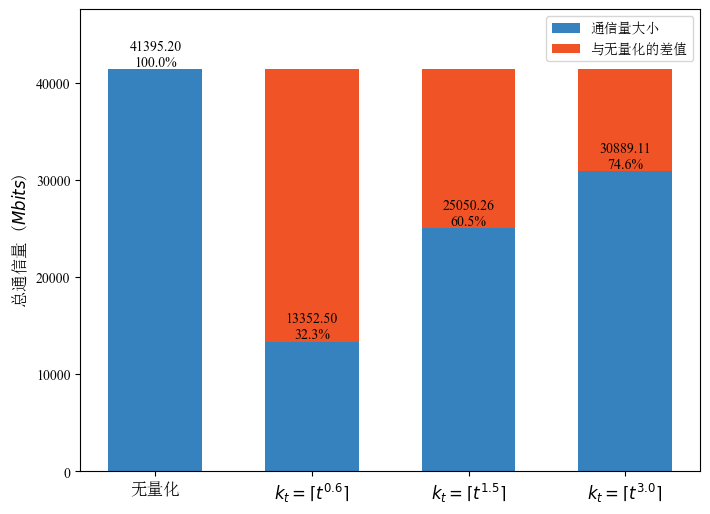

In [39]:
# 假设 chinese_font 已经定义
# 定义每个柱子的颜色
colors = ["#93c555", "#f05326", "#3682be", "#45a776"]

# 数据
categories = ['无量化',  
               r"$k_t=\lceil t^{0.6} \rceil$",  
               r"$k_t=\lceil t^{1.5} \rceil$",  
               r"$k_t=\lceil t^{3.0} \rceil$"]

values = [
    bit_counter.record_ls_dict["original"][-1],
    bit_counter.record_ls_dict["0.6"][-1],
    bit_counter.record_ls_dict["1.5"][-1],
    bit_counter.record_ls_dict["3.0"][-1]
]

fig, ax = plt.subplots(figsize=(8, 6))

# 数据准备（假设这是您的数据，这里补充了示例数据以便测试）

original_value = values[0]
x_positions = range(len(categories))

# 先绘制原始柱子
bar0 = ax.bar(0, original_value, color="#3682be", width=0.6, label='通信量大小')

ax.text(
    0, original_value, 
    f"{original_value:.2f}\n100.0%",  # 修复1：原始值没有减少，显示0%
    ha='center', va='bottom',
    color='black', fontsize=10
)

# 绘制量化柱子及红色差值
for i in range(1, 4):
    value = values[i]
    diff = original_value - value
    percentage_diff = (value / original_value) * 100  # 修复2：计算减少的百分比
    
    # 绘制本量化方法实际值（底部）
    ax.bar(i, value, color="#3682be", width=0.6)

    if i == 1:
        ax.bar(i, diff, bottom=value, color='#f05326', width=0.6, label='与无量化的差值')
    else:
        ax.bar(i, diff, bottom=value, color='#f05326', width=0.6)
    
    # 添加实际值标签（白色文字）
    ax.text(
        i, value, f"{value:.2f}\n{percentage_diff:.1f}%",
        ha='center', va='bottom',
        color='black', fontsize=10
    )


# 移除重复的原始值标签代码（原代码最后多余的text调用）

# 美化设置
ax.set_xticks(x_positions)
ax.set_xticklabels(categories,fontsize=12,fontproperties=chinese_font)  # 假设已设置中文字体
ax.set_ylabel('总通信量 ($Mbits$)',fontsize=12,fontproperties=chinese_font)
ax.set_ylim(top=original_value * 1.15)
# 添加图例（调整位置在左上角，避免遮挡）
ax.legend(loc='upper right', frameon=True,prop=chinese_font)

# 保存设置
plt.savefig(
    f"figs/cal-communication-bar-q-dadam-ps-muilt-lr-{data_name}.png",
    dpi=300, bbox_inches='tight', 
    pad_inches=0.1
)
plt.show()

### 英文绘图

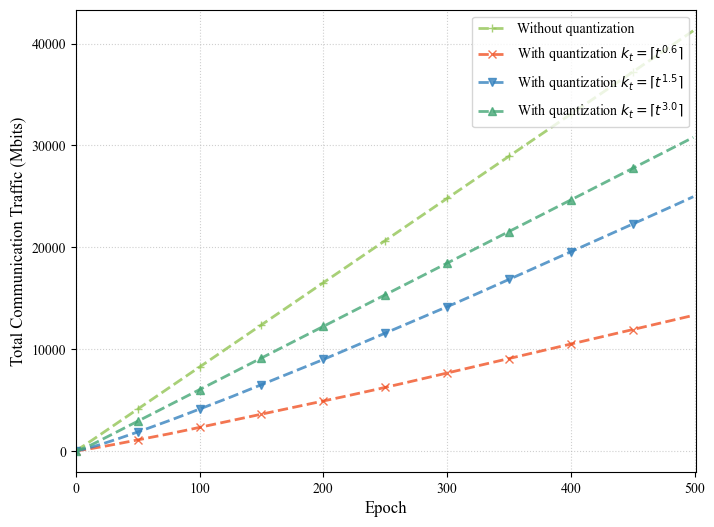

In [44]:

color_ls = ["93c555","f05326","3682be","45a776"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

record_dict={
    "total_original_bits":bit_counter.record_ls_dict["original"],
    "total_quantized_bits_0p6":bit_counter.record_ls_dict["0.6"],
     "total_quantized_bits_1p5":bit_counter.record_ls_dict["1.5"],
     "total_quantized_bits_3p0":bit_counter.record_ls_dict["3.0"],
}

name_dict={
    "total_original_bits":"Without quantization",
    "total_quantized_bits_0p6":r"With quantization $k_t=\lceil t^{0.6} \rceil$",
    "total_quantized_bits_1p5":r"With quantization $k_t=\lceil t^{1.5} \rceil$",
    "total_quantized_bits_3p0":r"With quantization $k_t=\lceil t^{3.0} \rceil$",
}

fig, ax1 = plt.subplots(
        figsize=(8, 6),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_dict):
    ls=record_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6), '--', linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=name_dict[key])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Total Communication Traffic (Mbits)', fontsize=12)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="pdf"
fig.savefig(
    fname=f"figs_en/cal-communication-q-dadam-ps-muilt-lr-{data_name}_en.{ext}",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


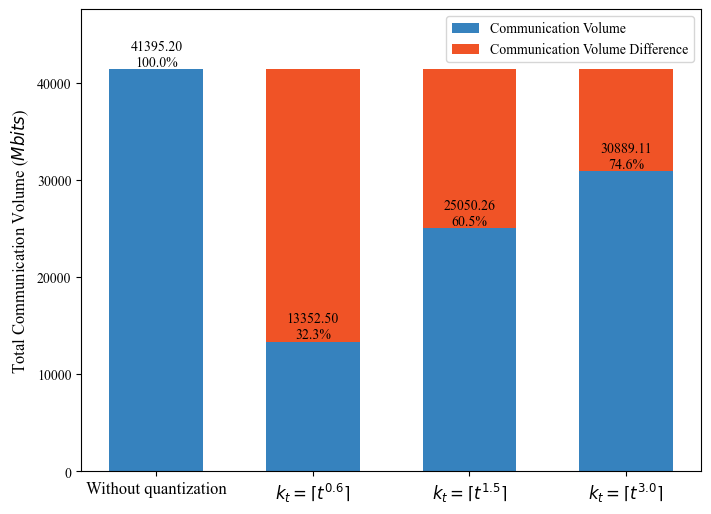

In [43]:
# 假设 chinese_font 已经定义
# 定义每个柱子的颜色
colors = ["#93c555", "#f05326", "#3682be", "#45a776"]

# 数据
categories = ['Without quantization',  
               r"$k_t=\lceil t^{0.6} \rceil$",  
               r"$k_t=\lceil t^{1.5} \rceil$",  
               r"$k_t=\lceil t^{3.0} \rceil$"]

values = [
    bit_counter.record_ls_dict["original"][-1],
    bit_counter.record_ls_dict["0.6"][-1],
    bit_counter.record_ls_dict["1.5"][-1],
    bit_counter.record_ls_dict["3.0"][-1]
]

fig, ax = plt.subplots(figsize=(8, 6))

# 数据准备（假设这是您的数据，这里补充了示例数据以便测试）

original_value = values[0]
x_positions = range(len(categories))

# 先绘制原始柱子
bar0 = ax.bar(0, original_value, color="#3682be", width=0.6, label='Communication Volume')

ax.text(
    0, original_value, 
    f"{original_value:.2f}\n100.0%",  # 修复1：原始值没有减少，显示0%
    ha='center', va='bottom',
    color='black', fontsize=10
)

# 绘制量化柱子及红色差值
for i in range(1, 4):
    value = values[i]
    diff = original_value - value
    percentage_diff = (value / original_value) * 100  # 修复2：计算减少的百分比
    
    # 绘制本量化方法实际值（底部）
    ax.bar(i, value, color="#3682be", width=0.6)

    if i == 1:
        ax.bar(i, diff, bottom=value, color='#f05326', width=0.6, label='Communication Volume Difference')
    else:
        ax.bar(i, diff, bottom=value, color='#f05326', width=0.6)
    
    # 添加实际值标签（白色文字）
    ax.text(
        i, value, f"{value:.2f}\n{percentage_diff:.1f}%",
        ha='center', va='bottom',
        color='black', fontsize=10
    )


# 移除重复的原始值标签代码（原代码最后多余的text调用）

# 美化设置
ax.set_xticks(x_positions)
ax.set_xticklabels(categories,fontsize=12)  # 假设已设置中文字体
ax.set_ylabel('Total Communication Volume ($Mbits$)',fontsize=12)
ax.set_ylim(top=original_value * 1.15)
# 添加图例（调整位置在左上角，避免遮挡）
ax.legend(loc='upper right', frameon=True)
ext="pdf"
# 保存设置
plt.savefig(
    f"figs_en/cal-communication-bar-q-dadam-ps-muilt-lr-{data_name}_en.{ext}",
    format=ext,
    dpi=300, bbox_inches='tight', 
    pad_inches=0.1
)
plt.show()

In [ ]:
# 导出所有数据，并绘制到tensorboard
recorded_data=training_recorder.get_all_data_for_writer_scalars()
for measure,recorder_ls in recorded_data.items():
    epoch=0
    for d in recorder_ls:
        writer.add_scalars(measure,d,epoch)
        epoch=epoch+1